## Import Statements

In [46]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

In [42]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from math import sqrt

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import gen_even_slices

## Function to Compute Metrics

In [45]:
def compute_metrics(y_true, y_pred, sample_weight=None):

    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

        y_true = y_true[mask]
        y_pred = y_pred[mask]
        if sample_weight is not None:
            sample_weight = sample_weight[mask]

    return {
        'mse': mean_squared_error(y_true, y_pred, sample_weight=sample_weight),
        'rmse': sqrt(mean_squared_error(y_true, y_pred, sample_weight=sample_weight)),
        'mean poisson deviance': mean_poisson_deviance(y_true, y_pred, sample_weight=sample_weight)
    }

## Function to Calculate Calibration Curve

In [48]:
def _calibration_curve_weighted(y_true, y_pred, n_bins=10, sample_weight=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    idx_sort = np.argsort(y_pred)
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight)

    for i, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        if sample_weight is None:
            y_pred_bin[i] = np.average(y_pred[idx_sort][sl])
            y_true_bin[i] = np.average(y_true[idx_sort][sl])
        else:
            weights = sample_weight[idx_sort][sl]
            y_pred_bin[i] = np.average(y_pred[idx_sort][sl], weights=weights)
            y_true_bin[i] = np.average(y_true[idx_sort][sl], weights=weights)
    return y_pred_bin, y_true_bin

def plot_calibration_curve_regression(y_true, y_pred, n_bins=10, ax=None, title="", sample_weight=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_bin, y_true_bin = _calibration_curve_weighted(y_test, y_pred, sample_weight=sample_weight)

    bin_centers = np.arange(1, len(y_pred_bin) + 1)
    ax.plot(bin_centers, y_pred_bin, marker='x', linestyle="--", label="predictions")
    ax.plot(bin_centers, y_true_bin, marker='o', linestyle="--", label="observations")
    ax.set(xlabel="Bin number", xticks=bin_centers, title=title)
    ax.legend()
    return ax

## Data Preprocessing

In [51]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-01-01', end='2026-12-31')

In [7]:
data_import = pd.read_csv('Data/Daily_attendance.csv')

In [8]:
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

In [9]:
all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()
all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day

In [10]:
all_years_test['federal_holiday_flag'] = all_years_test.index.isin(holidays)

all_years_test['school_holiday_flag'] = all_years_test.index.isin(all_years_test.index[(all_years_test.index.month >= 6) & (all_years_test.index.month <= 8)])
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

These columns are dropped from the dataset and not used in the model

In [11]:
all_years_test.drop(columns=['snow_1h', 'temp_max', 'temp_min','YEAR', 'wind_gust', 'pressure'], inplace=True)

## Test Train Split

In [15]:
X = all_years_test[['temp', 'humidity', 'wind_speed', 'rain_1h', 'federal_holiday_flag', 'school_holiday_flag', 'MONTH', 'DAY_OF_WEEK', 'DAY']]
y = all_years_test['value']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Standardisation and One Hot Encoding

In [31]:
numerical_features = ['temp', 'humidity', 'wind_speed', 'rain_1h']
cat_features = ['federal_holiday_flag', 'school_holiday_flag', 'MONTH', 'DAY_OF_WEEK','DAY']

ct = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical', OneHotEncoder(sparse=False, handle_unknown='error', drop='if_binary'), cat_features)
])

## Grid Search for Hyperparameter Tuning

In [33]:
n_estimators = [500, 600, 700, 800, 900, 1000]
max_depth = [1, 2, 3, 4, 5]
learning_rate = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
min_child_weight = [3, 4, 5]
base_score = [0.1, 0.2, 0.5, 0.75, 0.8]
objective = ['count:poisson']

param_grid = dict(n_estimators = n_estimators,
                  max_depth = max_depth,
                  learning_rate = learning_rate,
                  min_child_weight = min_child_weight,
                  # base_score = base_score,
                  objective = objective)

grid_search_xgb = Pipeline([
    ('prep', ct),
    ('reg', GridSearchCV(estimator=XGBRegressor(), cv =3, param_grid=param_grid, verbose=100, n_jobs=-1))
])

In [34]:
grid_search_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV 1/5; 1/630] START learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=500, objective=count:poisson
[CV 1/5; 1/630] END learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=500, objective=count:poisson;, score=-6.439 total time=   1.0s
[CV 2/5; 2/630] START learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=600, objective=count:poisson
[CV 2/5; 2/630] END learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=600, objective=count:poisson;, score=-4.277 total time=   1.3s
[CV 1/5; 3/630] START learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=700, objective=count:poisson
[CV 1/5; 3/630] END learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=700, objective=count:poisson;, score=-5.920 total time=   1.4s
[CV 5/5; 3/630] START learning_rate=0.01, max_depth=1, min_child_weight=3, n_estimators=700, objective=count:poisson
[CV 5/5; 3/630] END l

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'wind_speed', 'rain_1h']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  ['federal_holiday_flag',
                                                   'school_holiday_flag',
                                                   'MONTH', 'DAY_OF_WEEK',
                                                   'DAY'])])),
                ('reg',
                 GridSearchCV(estimator=XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample...
     

Best Model Parameters

In [35]:
print('Best Score: ', grid_search_xgb.steps[-1][1].best_score_)
print('Best Params: ', grid_search_xgb.steps[-1][1].best_params_)

Best Score:  0.37146759717984607
Best Params:  {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'count:poisson'}


## Fitting XG Boost Poisson Regressor

In [54]:
xgb = XGBRegressor(n_estimators= 500,
                   max_depth=1,
                   learning_rate=0.1,
                   min_child_weight=3,
                   booster='gbtree',
                   # base_score=0.75,
                   objective='count:poisson')

## Crossvalidation

In [55]:
cross_val_scores=cross_validate(xgb,X_train,y_train,cv=5,scoring=['neg_mean_squared_error','r2'],verbose=100,return_train_score=True,n_jobs=-1 )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


In [56]:
cross_val_scores['test_r2'].mean()

0.38212417270573296

## Final Model With Tuned Hyperparameter

In [57]:
final_xgb_pip = Pipeline([
    ('prep', ct),
    ('reg', XGBRegressor(n_estimators= 500,
                         max_depth=1,
                         learning_rate=0.1,
                         min_child_weight=3,
                         booster='gbtree',
                         # base_score=0.75,
                         objective='count:poisson'))
])

In [58]:
final_xgb_pip.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'wind_speed', 'rain_1h']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  ['federal_holiday_flag',
                                                   'school_holiday_flag',
                                                   'MONTH', 'DAY_OF_WEEK',
                                                   'DAY'])])),
                ('reg',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample...
                              interaction_constraints='', learning_rate=0.1,
   

### Metrics

In [59]:
xgb_test_pred = final_xgb_pip.predict(X_test)
compute_metrics(y_test, xgb_test_pred)

{'mse': 195239.82975779692,
 'rmse': 441.85951359883256,
 'mean poisson deviance': 167.60591518769488}

### Calibration Curve

<AxesSubplot:title={'center':'Ridge'}, xlabel='Bin number'>

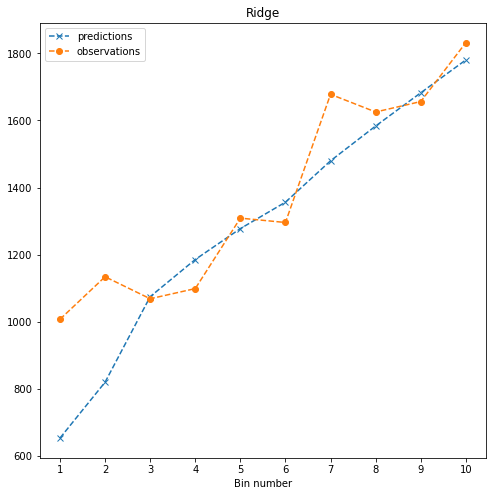

In [60]:
plot_calibration_curve_regression(y_test, xgb_test_pred, title="Ridge")

## Out of Sample Prediction

In [64]:
out_of_sample_dataset = pd.read_csv('Data/out_of_sample.csv')
out_of_sample_dataset.set_index('Full_Date', inplace=True)
out_of_sample_dataset.index = pd.to_datetime(out_of_sample_dataset.index)

In [65]:
out_of_sample_pred = final_xgb_pip.predict(out_of_sample_dataset)